# TER M1 IASD 2025

Sonia KECHAOU,

Rim LEMRABOTT,

Fannie RUIZ

Un modèle BilSTM avec mécanisme d’Attention

Voir section 3.5  *Un modèle avec mécanisme d’Attention* du rapport.




In [ ]:
import numpy as np
import pandas as pd
import ast
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import csv
import time
import os

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Dense, TimeDistributed, AdditiveAttention, Concatenate, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import RMSprop

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
def save_training_info(model, history, params, save_dir="training_logs"):
    os.makedirs(save_dir, exist_ok=True)
    timestamp = time.strftime("%Y%m%d-%H%M%S")
    model.save_weights(os.path.join(save_dir, f'model_weights_{timestamp}.weights.h5'))

    with open(os.path.join(save_dir, f'model_architecture_{timestamp}.json'), 'w') as f:
        f.write(model.to_json())

    with open(os.path.join(save_dir, f'training_params_{timestamp}.csv'), 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["Paramètre", "Valeur"])
        for key, value in params.items():
            writer.writerow([key, value])

    with open(os.path.join(save_dir, f'training_history_{timestamp}.csv'), 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["Epoch", "Loss", "Accuracy", "Val Loss", "Val Accuracy"])
        for i in range(len(history.history['loss'])):
            writer.writerow([
                i + 1,
                history.history['loss'][i],
                history.history.get('accuracy', [None] * len(history.history['loss']))[i],
                history.history.get('val_loss', [None] * len(history.history['loss']))[i],
                history.history.get('val_accuracy', [None] * len(history.history['loss']))[i]
            ])

    print(f"Training information saved in {save_dir}")

In [ ]:
def plot_confusion_matrix(conf_matrix, title="Matrice de confusion", labels=None,cmap="Blues"):

    if labels is None:
      labels = [f"Classe {i}" for i in range(conf_matrix.shape[0])]

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=cmap, xticklabels=labels,yticklabels=labels)
    plt.title(title)
    plt.ylabel("Classe Réelle")
    plt.xlabel("Classe Prédite")
    plt.tight_layout()
    plt.show()

In [ ]:
def load_glove_embeddings(glove_path, embedding_dim):
    embeddings_index = {}
    with open(glove_path, encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

In [ ]:
def decode_sentence(sequence):
    return " ".join([vocab[idx] for idx in sequence if idx > 0])

def decode_tags(sequence):
  return [tags[idx] for idx in sequence]

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

my_local_drive='/content/gdrive/My Drive/Colab Notebooks/TER'
sys.path.append(my_local_drive)
%cd $my_local_drive

%pwd

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
/content/gdrive/My Drive/Colab Notebooks/TER


'/content/gdrive/My Drive/Colab Notebooks/TER'

In [ ]:
df = pd.read_csv('dataset/ner80pourcents.csv', sep=';')
df['Tag'] = df['Tag'].apply(lambda x: ast.literal_eval(x))

texts = df['Sentence'].values.tolist()
labels = df['Tag'].values.tolist()
tags = ['O','B-org','I-org','B-gpe','I-gpe','B-per','I-per','B-eve','I-eve','B-nat','I-nat','B-art','I-art','B-geo','I-geo','B-tim','I-tim']

tag2idx = { 'O': 0,
            'B-org': 1,   #Organization
            'I-org': 2,
            'B-gpe': 3,   #Geopolitical Entity
            'I-gpe': 4,
            'B-per': 5,   #Person
            'I-per': 6,
            'B-eve': 7,   #Event
            'I-eve': 8,
            'B-nat': 9,   #Natural Phenomenon
            'I-nat': 10,
            'B-art': 11,  #Artifact
            'I-art': 12,
            'B-geo': 13,  #Geographical Entity
            'I-geo': 14,
            'B-tim': 15,  #Time indicator
            'I-tim': 16}


num_labels = len(tags)
max_len = 62

sentence_vectorizer = layers.TextVectorization(output_sequence_length=max_len, standardize=None)
sentence_vectorizer.adapt(texts)
vocab = sentence_vectorizer.get_vocabulary()
vocab = [str(word) for word in vocab]
vocab_size = len(vocab)+1


X = sentence_vectorizer(texts)
X = [seq.numpy().tolist() if isinstance(seq, tf.Tensor) else seq for seq in X]
word_to_index = {word: index for index, word in enumerate(vocab)}
y = [[tag2idx[tag] for tag in seq] for seq in labels]
y = pad_sequences(y, maxlen=max_len, value=tag2idx['O'], padding="post", truncating="post")
y = np.array([to_categorical(labels, num_classes=num_labels) for labels in y])
X = np.array(X)
y = np.array(y)

print(X[:2])
print(y[:2])

[[  11  120  476  357  216   16    7  512  240  210    6   67    5 1185
    49   14 1471    7 2336    7   64   10 3217    6 4275 1031 8924    3
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]
 [  11   91   83    4   15   18 2686    4   13 1084    7 2609   64    7
     2   70  107  127    4   95  290 2816  403  260   54 8715  304   13
  3455    2 1952 2162 1393    3    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]]
[[[1. 0. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]

 [[1. 0. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]]


In [ ]:
glove_path = 'glove.6B.100d.txt'
embedding_dim = 100
embeddings_index = load_glove_embeddings(glove_path, embedding_dim)
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_to_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
kfold = KFold(n_splits=8, random_state=42, shuffle=True)

Fold 1


Model: "medical_lstm_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 62)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_layer           │ (None, 62, 100)        │      2,047,900 │ input_layer[0][0]      │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bi_lstm_layer             │ (None, 62, 250)        │        226,000 │ embedding_layer[0][0]  │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_layer           │ (None, 62, 250)        │            250 │ bi_lstm_layer[0][0],   │
│ (AdditiveAttention)       │                        │                │ bi_lstm_layer[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_8             │ (None, 62, 500)        │              0 │ bi_lstm_layer[0][0],   │
│ (Concatenate)             │                        │                │ attention_layer[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (None, 62, 500)        │              0 │ concatenate_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output_layer              │ (None, 62, 17)         │          8,517 │ dropout_8[0][0]        │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,282,667 (8.71 MB)

 Trainable params: 234,767 (917.06 KB)

 Non-trainable params: 2,047,900 (7.81 MB)

Epoch 1/40
297/299 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8932 - loss: 0.3925
Epoch 1: val_loss improved from inf to 0.17412, saving model to ./modelCheckpoint/modelChkpt.keras
299/299 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - accuracy: 0.8934 - loss: 0.3911 - val_accuracy: 0.9426 - val_loss: 0.1741
Epoch 2/40
297/299 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9403 - loss: 0.1803
Epoch 2: val_loss improved from 0.17412 to 0.15876, saving model to ./modelCheckpoint/modelChkpt.keras
299/299 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - accuracy: 0.9403 - loss: 0.1802 - val_accuracy: 0.9461 - val_loss: 0.1588
Epoch 3/40
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9457 - loss: 0.1646
Epoch 3: val_loss improved from 0.15876 to 0.14435, saving model to ./modelCheckpoint/modelChkpt.keras
299/299 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 0.9457 - loss: 0.1646 - val_accuracy: 0.9515 - val_loss: 0.1443
Epoch 4/40
297/299 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9488 - loss

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model: "medical_lstm_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 62)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_layer           │ (None, 62, 100)        │      2,047,900 │ input_layer[0][0]      │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bi_lstm_layer             │ (None, 62, 250)        │        226,000 │ embedding_layer[0][0]  │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_layer           │ (None, 62, 250)        │            250 │ bi_lstm_layer[0][0],   │
│ (AdditiveAttention)       │                        │                │ bi_lstm_layer[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_9             │ (None, 62, 500)        │              0 │ bi_lstm_layer[0][0],   │
│ (Concatenate)             │                        │                │ attention_layer[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_9 (Dropout)       │ (None, 62, 500)        │              0 │ concatenate_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output_layer              │ (None, 62, 17)         │          8,517 │ dropout_9[0][0]        │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,282,667 (8.71 MB)

 Trainable params: 234,767 (917.06 KB)

 Non-trainable params: 2,047,900 (7.81 MB)

Epoch 1/40
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8926 - loss: 0.3919
Epoch 1: val_loss improved from inf to 0.17882, saving model to ./modelCheckpoint/modelChkpt.keras
299/299 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - accuracy: 0.8927 - loss: 0.3914 - val_accuracy: 0.9403 - val_loss: 0.1788
Epoch 2/40
297/299 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9402 - loss: 0.1818
Epoch 2: val_loss improved from 0.17882 to 0.16088, saving model to ./modelCheckpoint/modelChkpt.keras
299/299 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.9402 - loss: 0.1817 - val_accuracy: 0.9464 - val_loss: 0.1609
Epoch 3/40
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9456 - loss: 0.1651
Epoch 3: val_loss improved from 0.16088 to 0.14539, saving model to ./modelCheckpoint/modelChkpt.keras
299/299 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.9456 - loss: 0.1651 - val_accuracy: 0.9513 - val_loss: 0.1454
Epoch 4/40
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9478 - loss

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model: "medical_lstm_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 62)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_layer           │ (None, 62, 100)        │      2,047,900 │ input_layer[0][0]      │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bi_lstm_layer             │ (None, 62, 250)        │        226,000 │ embedding_layer[0][0]  │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_layer           │ (None, 62, 250)        │            250 │ bi_lstm_layer[0][0],   │
│ (AdditiveAttention)       │                        │                │ bi_lstm_layer[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_10            │ (None, 62, 500)        │              0 │ bi_lstm_layer[0][0],   │
│ (Concatenate)             │                        │                │ attention_layer[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_10 (Dropout)      │ (None, 62, 500)        │              0 │ concatenate_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output_layer              │ (None, 62, 17)         │          8,517 │ dropout_10[0][0]       │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,282,667 (8.71 MB)

 Trainable params: 234,767 (917.06 KB)

 Non-trainable params: 2,047,900 (7.81 MB)

Epoch 1/40
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8940 - loss: 0.3867
Epoch 1: val_loss improved from inf to 0.17566, saving model to ./modelCheckpoint/modelChkpt.keras
299/299 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.8941 - loss: 0.3863 - val_accuracy: 0.9397 - val_loss: 0.1757
Epoch 2/40
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9403 - loss: 0.1794
Epoch 2: val_loss improved from 0.17566 to 0.15315, saving model to ./modelCheckpoint/modelChkpt.keras
299/299 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - accuracy: 0.9403 - loss: 0.1794 - val_accuracy: 0.9490 - val_loss: 0.1532
Epoch 3/40
298/299 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9469 - loss: 0.1601
Epoch 3: val_loss improved from 0.15315 to 0.15144, saving model to ./modelCheckpoint/modelChkpt.keras
299/299 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.9469 - loss: 0.1601 - val_accuracy: 0.9486 - val_loss: 0.1514
Epoch 4/40
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9487 - los

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model: "medical_lstm_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 62)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_layer           │ (None, 62, 100)        │      2,047,900 │ input_layer[0][0]      │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bi_lstm_layer             │ (None, 62, 250)        │        226,000 │ embedding_layer[0][0]  │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_layer           │ (None, 62, 250)        │            250 │ bi_lstm_layer[0][0],   │
│ (AdditiveAttention)       │                        │                │ bi_lstm_layer[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_11            │ (None, 62, 500)        │              0 │ bi_lstm_layer[0][0],   │
│ (Concatenate)             │                        │                │ attention_layer[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_11 (Dropout)      │ (None, 62, 500)        │              0 │ concatenate_11[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output_layer              │ (None, 62, 17)         │          8,517 │ dropout_11[0][0]       │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,282,667 (8.71 MB)

 Trainable params: 234,767 (917.06 KB)

 Non-trainable params: 2,047,900 (7.81 MB)

Epoch 1/40
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8958 - loss: 0.3811
Epoch 1: val_loss improved from inf to 0.17541, saving model to ./modelCheckpoint/modelChkpt.keras
299/299 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - accuracy: 0.8959 - loss: 0.3806 - val_accuracy: 0.9417 - val_loss: 0.1754
Epoch 2/40
297/299 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9402 - loss: 0.1808
Epoch 2: val_loss improved from 0.17541 to 0.15835, saving model to ./modelCheckpoint/modelChkpt.keras
299/299 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - accuracy: 0.9402 - loss: 0.1808 - val_accuracy: 0.9468 - val_loss: 0.1583
Epoch 3/40
297/299 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9458 - loss: 0.1630
Epoch 3: val_loss improved from 0.15835 to 0.14985, saving model to ./modelCheckpoint/modelChkpt.keras
299/299 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.9458 - loss: 0.1630 - val_accuracy: 0.9498 - val_loss: 0.1498
Epoch 4/40
297/299 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9487 - los

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model: "medical_lstm_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 62)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_layer           │ (None, 62, 100)        │      2,047,900 │ input_layer[0][0]      │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bi_lstm_layer             │ (None, 62, 250)        │        226,000 │ embedding_layer[0][0]  │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_layer           │ (None, 62, 250)        │            250 │ bi_lstm_layer[0][0],   │
│ (AdditiveAttention)       │                        │                │ bi_lstm_layer[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_12            │ (None, 62, 500)        │              0 │ bi_lstm_layer[0][0],   │
│ (Concatenate)             │                        │                │ attention_layer[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_12 (Dropout)      │ (None, 62, 500)        │              0 │ concatenate_12[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output_layer              │ (None, 62, 17)         │          8,517 │ dropout_12[0][0]       │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,282,667 (8.71 MB)

 Trainable params: 234,767 (917.06 KB)

 Non-trainable params: 2,047,900 (7.81 MB)

Epoch 1/40
297/299 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8949 - loss: 0.3858
Epoch 1: val_loss improved from inf to 0.17665, saving model to ./modelCheckpoint/modelChkpt.keras
299/299 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - accuracy: 0.8952 - loss: 0.3845 - val_accuracy: 0.9413 - val_loss: 0.1767
Epoch 2/40
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9403 - loss: 0.1799
Epoch 2: val_loss improved from 0.17665 to 0.15387, saving model to ./modelCheckpoint/modelChkpt.keras
299/299 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.9403 - loss: 0.1798 - val_accuracy: 0.9480 - val_loss: 0.1539
Epoch 3/40
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9455 - loss: 0.1640
Epoch 3: val_loss improved from 0.15387 to 0.14806, saving model to ./modelCheckpoint/modelChkpt.keras
299/299 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.9455 - loss: 0.1639 - val_accuracy: 0.9496 - val_loss: 0.1481
Epoch 4/40
297/299 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9494 - los

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me

Model: "medical_lstm_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 62)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_layer           │ (None, 62, 100)        │      2,047,900 │ input_layer[0][0]      │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bi_lstm_layer             │ (None, 62, 250)        │        226,000 │ embedding_layer[0][0]  │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_layer           │ (None, 62, 250)        │            250 │ bi_lstm_layer[0][0],   │
│ (AdditiveAttention)       │                        │                │ bi_lstm_layer[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_13            │ (None, 62, 500)        │              0 │ bi_lstm_layer[0][0],   │
│ (Concatenate)             │                        │                │ attention_layer[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_13 (Dropout)      │ (None, 62, 500)        │              0 │ concatenate_13[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output_layer              │ (None, 62, 17)         │          8,517 │ dropout_13[0][0]       │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,282,667 (8.71 MB)

 Trainable params: 234,767 (917.06 KB)

 Non-trainable params: 2,047,900 (7.81 MB)

Epoch 1/40
297/299 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8986 - loss: 0.3793
Epoch 1: val_loss improved from inf to 0.17648, saving model to ./modelCheckpoint/modelChkpt.keras
299/299 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - accuracy: 0.8988 - loss: 0.3780 - val_accuracy: 0.9407 - val_loss: 0.1765
Epoch 2/40
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9400 - loss: 0.1817
Epoch 2: val_loss improved from 0.17648 to 0.16046, saving model to ./modelCheckpoint/modelChkpt.keras
299/299 ━━━━━━━━━━━━━━━━━━━━ 20s 34ms/step - accuracy: 0.9400 - loss: 0.1817 - val_accuracy: 0.9458 - val_loss: 0.1605
Epoch 3/40
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9459 - loss: 0.1642
Epoch 3: val_loss improved from 0.16046 to 0.14775, saving model to ./modelCheckpoint/modelChkpt.keras
299/299 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.9460 - loss: 0.1642 - val_accuracy: 0.9502 - val_loss: 0.1477
Epoch 4/40
297/299 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9485 - los

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model: "medical_lstm_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 62)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_layer           │ (None, 62, 100)        │      2,047,900 │ input_layer[0][0]      │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bi_lstm_layer             │ (None, 62, 250)        │        226,000 │ embedding_layer[0][0]  │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_layer           │ (None, 62, 250)        │            250 │ bi_lstm_layer[0][0],   │
│ (AdditiveAttention)       │                        │                │ bi_lstm_layer[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_14            │ (None, 62, 500)        │              0 │ bi_lstm_layer[0][0],   │
│ (Concatenate)             │                        │                │ attention_layer[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_14 (Dropout)      │ (None, 62, 500)        │              0 │ concatenate_14[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output_layer              │ (None, 62, 17)         │          8,517 │ dropout_14[0][0]       │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,282,667 (8.71 MB)

 Trainable params: 234,767 (917.06 KB)

 Non-trainable params: 2,047,900 (7.81 MB)

Epoch 1/40
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8941 - loss: 0.3836
Epoch 1: val_loss improved from inf to 0.17574, saving model to ./modelCheckpoint/modelChkpt.keras
299/299 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.8942 - loss: 0.3832 - val_accuracy: 0.9410 - val_loss: 0.1757
Epoch 2/40
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9418 - loss: 0.1761
Epoch 2: val_loss improved from 0.17574 to 0.15527, saving model to ./modelCheckpoint/modelChkpt.keras
299/299 ━━━━━━━━━━━━━━━━━━━━ 19s 32ms/step - accuracy: 0.9418 - loss: 0.1761 - val_accuracy: 0.9483 - val_loss: 0.1553
Epoch 3/40
297/299 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9462 - loss: 0.1631
Epoch 3: val_loss improved from 0.15527 to 0.14626, saving model to ./modelCheckpoint/modelChkpt.keras
299/299 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.9462 - loss: 0.1631 - val_accuracy: 0.9511 - val_loss: 0.1463
Epoch 4/40
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9488 - los

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model: "medical_lstm_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 62)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_layer           │ (None, 62, 100)        │      2,047,900 │ input_layer[0][0]      │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bi_lstm_layer             │ (None, 62, 250)        │        226,000 │ embedding_layer[0][0]  │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_layer           │ (None, 62, 250)        │            250 │ bi_lstm_layer[0][0],   │
│ (AdditiveAttention)       │                        │                │ bi_lstm_layer[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_15            │ (None, 62, 500)        │              0 │ bi_lstm_layer[0][0],   │
│ (Concatenate)             │                        │                │ attention_layer[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_15 (Dropout)      │ (None, 62, 500)        │              0 │ concatenate_15[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output_layer              │ (None, 62, 17)         │          8,517 │ dropout_15[0][0]       │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,282,667 (8.71 MB)

 Trainable params: 234,767 (917.06 KB)

 Non-trainable params: 2,047,900 (7.81 MB)

Epoch 1/40
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8946 - loss: 0.3855
Epoch 1: val_loss improved from inf to 0.17257, saving model to ./modelCheckpoint/modelChkpt.keras
299/299 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - accuracy: 0.8947 - loss: 0.3850 - val_accuracy: 0.9424 - val_loss: 0.1726
Epoch 2/40
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9400 - loss: 0.1805
Epoch 2: val_loss improved from 0.17257 to 0.15554, saving model to ./modelCheckpoint/modelChkpt.keras
299/299 ━━━━━━━━━━━━━━━━━━━━ 19s 32ms/step - accuracy: 0.9400 - loss: 0.1805 - val_accuracy: 0.9485 - val_loss: 0.1555
Epoch 3/40
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9465 - loss: 0.1629
Epoch 3: val_loss improved from 0.15554 to 0.14934, saving model to ./modelCheckpoint/modelChkpt.keras
299/299 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.9465 - loss: 0.1629 - val_accuracy: 0.9498 - val_loss: 0.1493
Epoch 4/40
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9489 - los

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


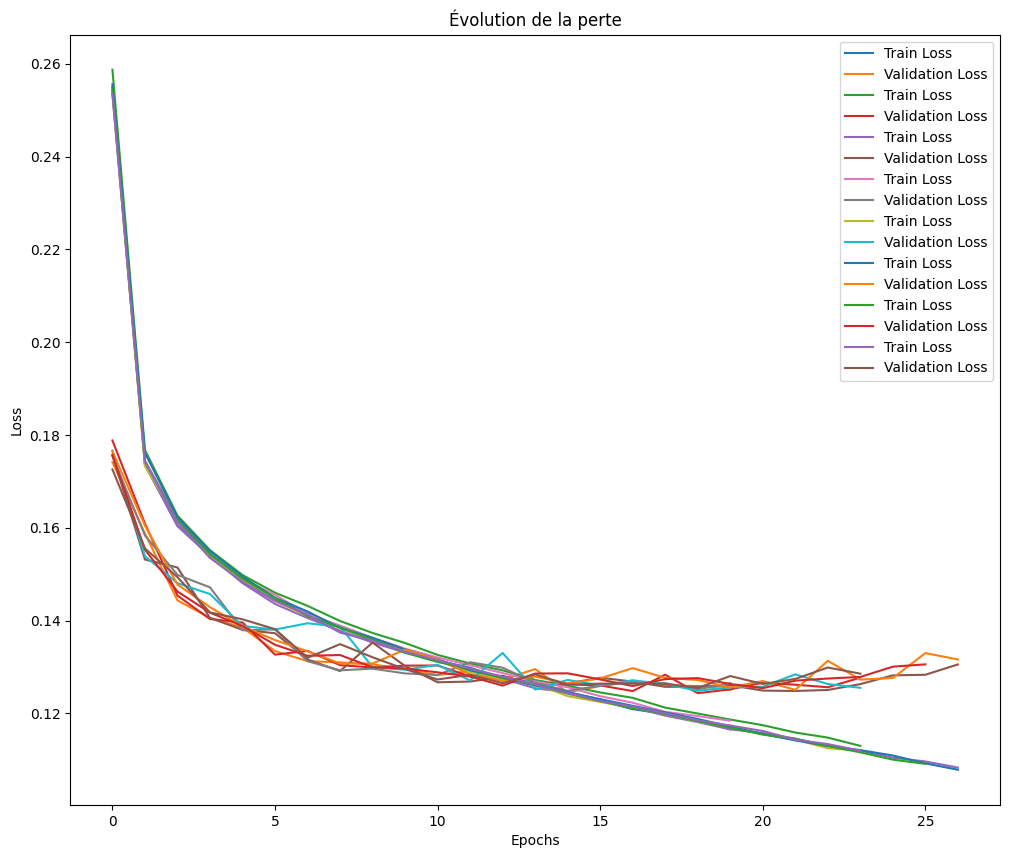

In [ ]:
scoresAcc = []
timestamp = time.strftime("%Y%m%d-%H%M%S")
model_name = "BiLSTMAttention"
plt.figure(figsize=(12, 10))

for fold, (train_index, test_index) in enumerate(kfold.split(X, y)):
    print(f"Fold {fold + 1}")

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    input_layer = Input(shape=(max_len,), name="input_layer")

    embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], trainable=False, name="embedding_layer")(input_layer)

    bi_lstm_layer = Bidirectional(LSTM(125, return_sequences=True, dropout=0.23198532973805824),name="bi_lstm_layer")(embedding_layer)

    attention_layer = AdditiveAttention(name="attention_layer")([bi_lstm_layer, bi_lstm_layer])

    merged_layer = Concatenate(axis=-1)([bi_lstm_layer, attention_layer])

    merged_layer = Dropout(0.23198532973805824)(merged_layer)

    output_layer = TimeDistributed(Dense(num_labels, activation="softmax"), name="output_layer")(merged_layer)

    model_lstm = Model(inputs=input_layer, outputs=output_layer, name="medical_lstm_model")

    optimizer = RMSprop(learning_rate=0.004325641526703663)
    model_lstm.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
    model_lstm.summary()

    params = {
        "epochs" : 40,
        "batch_size" : 32,
        "validation_split" : 0.2,
        "shuffle" : True,
        "callback" : ["checkpoint","earlystopping"]
    }


    checkpoint_filepath = './modelCheckpoint/modelChkpt.keras'
    model_checkpoint_callback = ModelCheckpoint(
      filepath=checkpoint_filepath,
      verbose=1,
      monitor='val_loss',
      mode='min',
      save_best_only=True)

    model_earlystopping_callback = EarlyStopping(
      verbose=1,
      monitor="val_loss",
      patience=5,
      mode="min")


    history_lstm = model_lstm.fit(X_train, y_train, epochs=params["epochs"], batch_size=params["batch_size"], validation_split=params["validation_split"], shuffle=params["shuffle"], callbacks=[model_checkpoint_callback,model_earlystopping_callback])
    loss, accuracy = model_lstm.evaluate(X_test, y_test)
    print(f"Loss: {loss}, Accuracy: {accuracy}")

    scoresAcc.append(accuracy)

    plt.plot(history_lstm.history['loss'], label='Train Loss')
    plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Évolution de la perte')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.savefig(f"plot{model_name}_{timestamp}.png")

    predictions = model_lstm.predict(X_test)
    y_pred = np.argmax(predictions, axis=-1)
    y_true = np.argmax(y_test, axis=-1)
    y_true_flat = [tag for seq in y_true for tag in seq]
    y_pred_flat = [tag for seq in y_pred for tag in seq]
    print(classification_report(y_true_flat, y_pred_flat, labels=list(tag2idx.values()), target_names=tags))

    for i in range(5):
      print(f"Phrase: {decode_sentence(X_test[i])}")
      print(f"Tags réels: {decode_tags(y_true[i])}")
      print(f"Tags prédits: {decode_tags(y_pred[i])}")
      print("-")

print(f"Score moyen : {np.mean(scoresAcc):.4f} ± {np.std(scoresAcc)}")


In [ ]:
save_training_info(model_lstm, history_lstm, params)

Training information saved in training_logs
